In [1]:
import time
import sys
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import scvelo as scv
import scanpy
import scipy
import seaborn as sns

from torch import optim
from veloproj import *
from sklearn.decomposition import PCA
from IPython import display
from matplotlib import pyplot as plt

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr', '7e-6', 
                               '--n-epochs', '20000', 
                               '--model-name', 'dentategyrus_model.cpt',
                               '--exp-name', 'CohAE_dentategyrus',
                               '--device', 'cuda:3'
                              ])

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [("OPC", "OL")]
k_cluster = "clusters"
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
adata = scv.datasets.dentategyrus()
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
print(adata)

10X43_1.h5ad: |          | 0.00/? [00:00<?, ?B/s]

Abundance of ['spliced', 'unspliced']: [0.9 0.1]
Filtered out 11019 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:13) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
AnnData object with n_obs × n_vars = 2930 × 2000
    obs: 'clusters', 'age(days)', 'clusters_enlarged', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_colors', 'pca', 'neighbors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'


computing velocities
    finished (0:00:00) --> added 
    'stc_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:06) --> added 
    'stc_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'stc_velocity_length' (adata.obs)
--> added 'stc_velocity_confidence' (adata.obs)
--> added 'stc_velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'stc_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_dentategyrus_stochastical.png


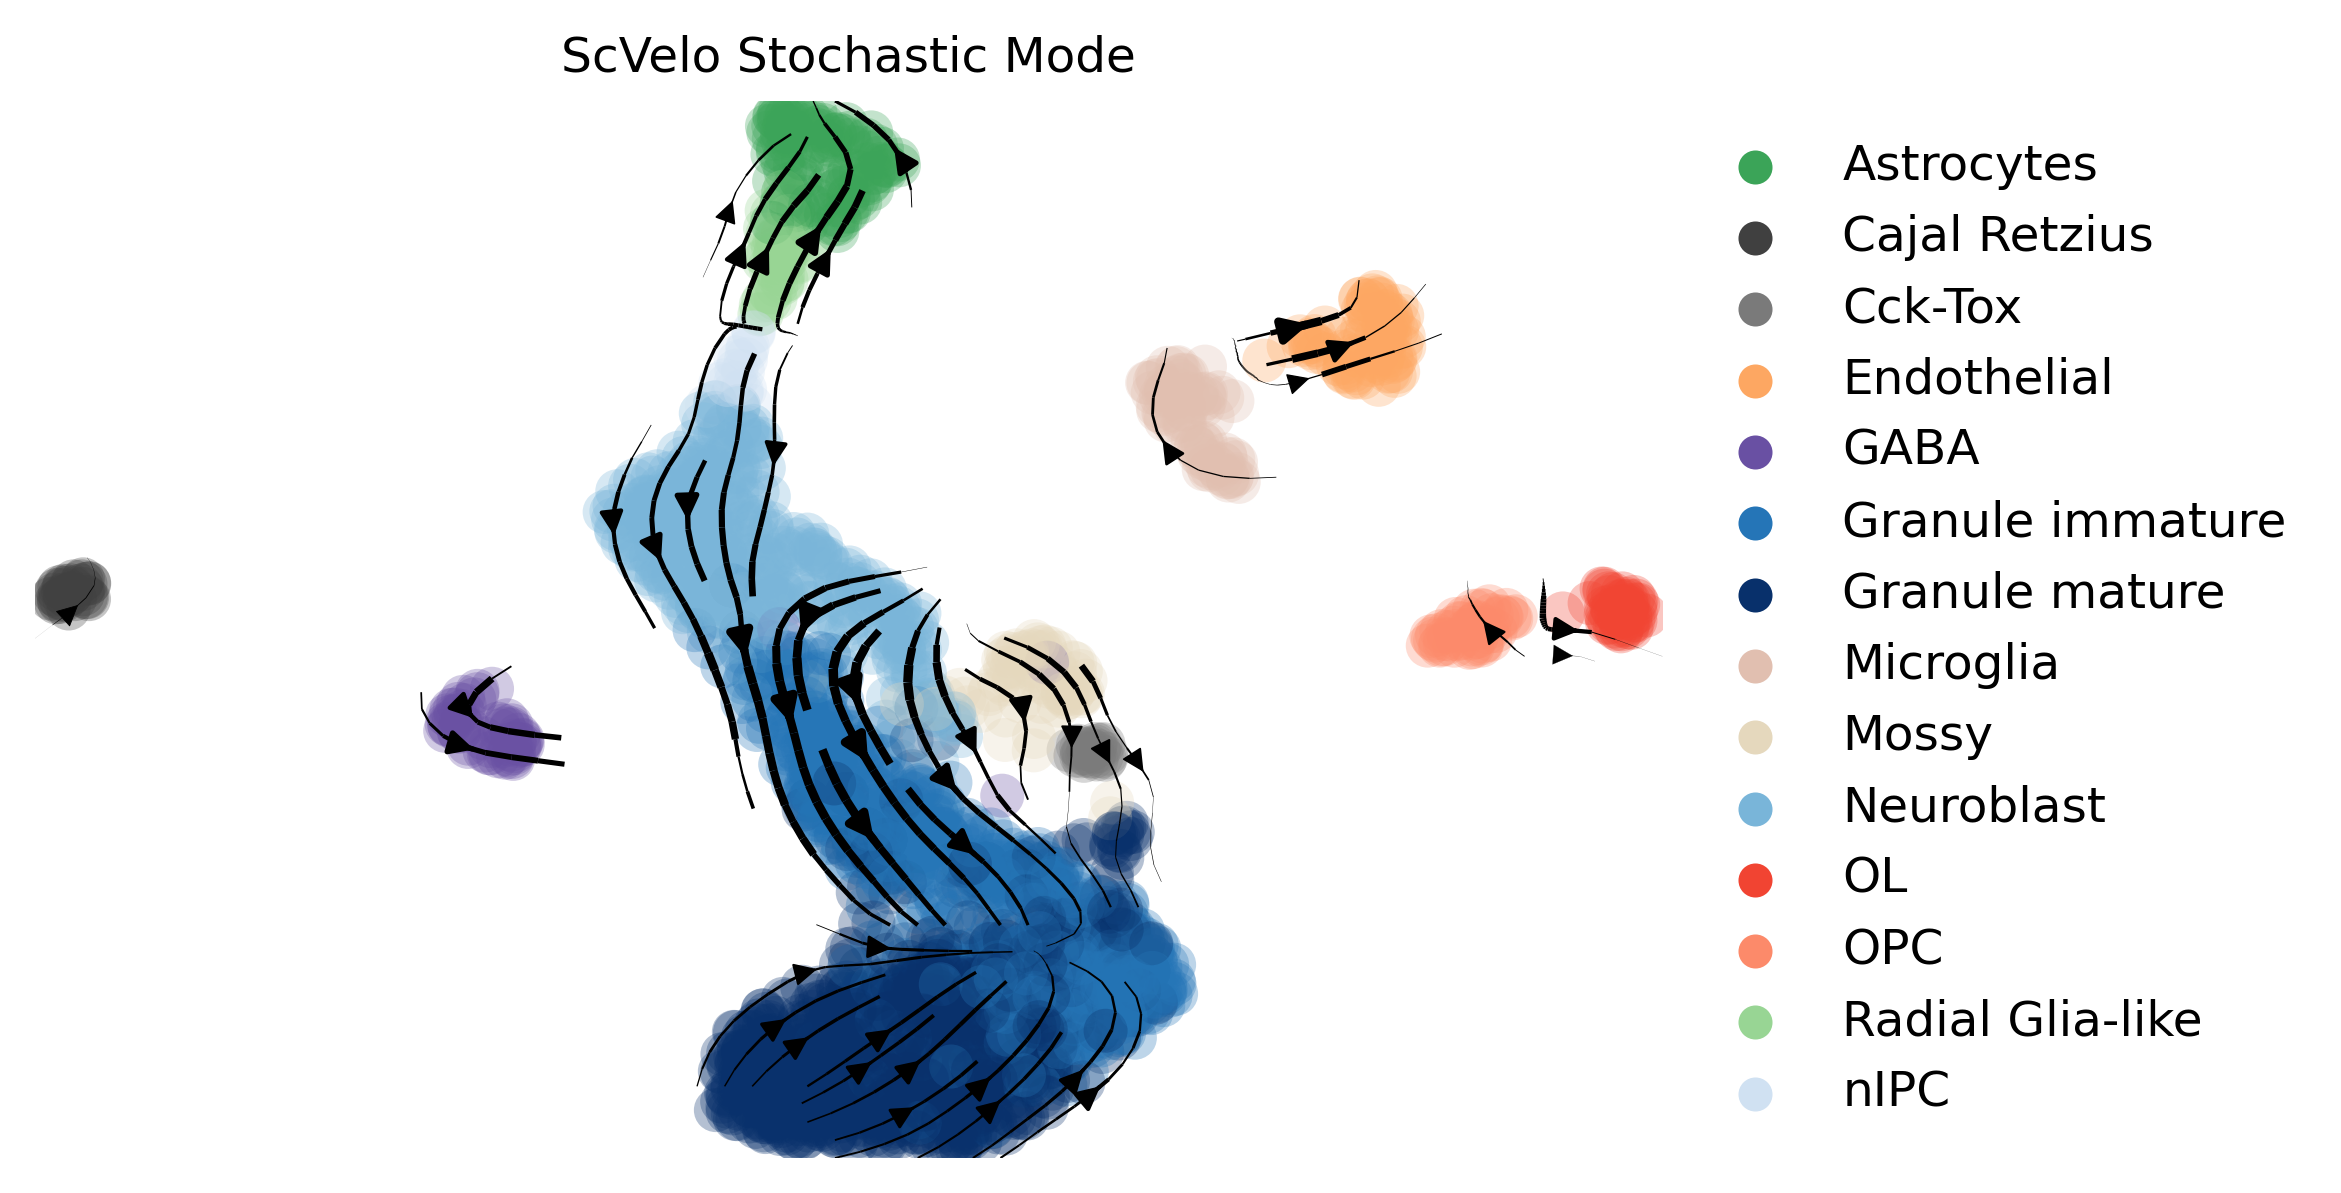

# Cross-Boundary Transition Score (A->B)
{('OPC', 'OL'): 0.0}
Total Mean: nan
# Cross-Boundary Velocity Coherence (A->B)
{('OPC', 'OL'): 0.5085378}
Total Mean: 0.5085378289222717
# Cross-Boundary Direction Correctness (A->B)
{('OPC', 'OL'): -0.8861011346479906}
Total Mean: -0.8861011346479906
# In-cluster Coherence
{'Astrocytes': 0.8558933, 'Cajal Retzius': 0.9876432, 'Cck-Tox': 0.9481789, 'Endothelial': 0.9474042, 'GABA': 0.90869683, 'Granule immature': 0.8450072, 'Granule mature': 0.80969536, 'Microglia': 0.9754837, 'Mossy': 0.89986753, 'Neuroblast': 0.9308812, 'OL': 0.9506476, 'OPC': 0.92203844, 'Radial Glia-like': 0.89049774, 'nIPC': 0.94443244}
Total Mean: 0.9154548048973083
# In-cluster Confidence
{'Astrocytes': 0.892010415593783, 'Cajal Retzius': 0.9845344126224518, 'Cck-Tox': 0.8860587852972525, 'Endothelial': 0.8625854274322247, 'GABA': 0.8818325673947569, 'Granule immature': 0.8406926885531966, 'Granule mature': 0.8008263841967717, 'Microglia': 0.8768389931431523, 'Mossy': 0.

In [6]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity')
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata,  legend_loc="right margin", vkey="stc_velocity", basis='X_umap', color=['clusters'],# 'age(days)'],
                                 dpi=350, 
                                 save="dentategyrus_stochastical.png",
                                title='ScVelo Stochastic Mode')
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, k_cluster, "stc_velocity")

recovering dynamics
    finished (0:28:49) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:07) --> added 
    'dyn_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:04) --> added 
    'dyn_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'dyn_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_dentategyrus_dynamical.png


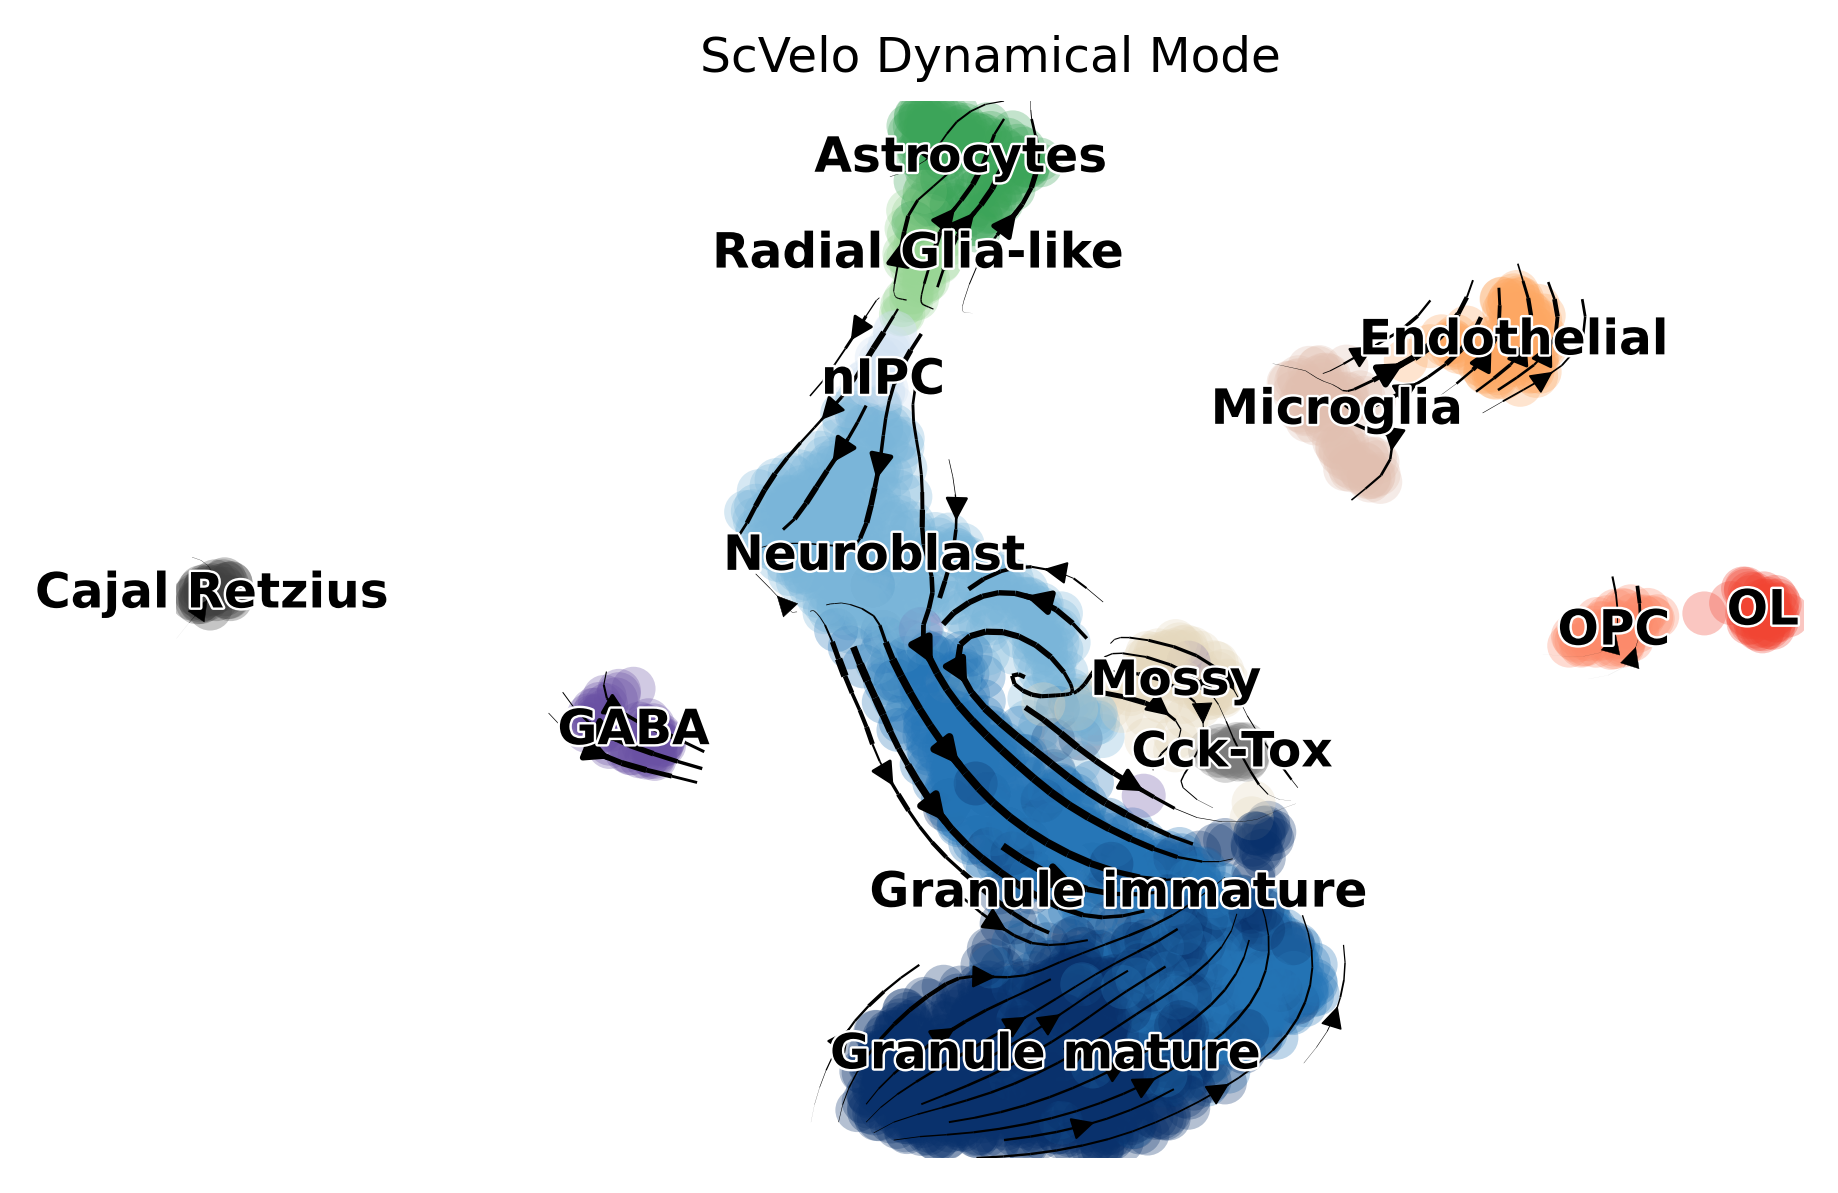

--> added 'dyn_velocity_length' (adata.obs)
--> added 'dyn_velocity_confidence' (adata.obs)
--> added 'dyn_velocity_confidence_transition' (adata.obs)


In [7]:
scv.tl.recover_dynamics(adata, max_iter=100, use_raw=False, var_names="all")
scv.tl.velocity(adata, vkey='dyn_velocity', mode='dynamical', use_raw=False)
scv.tl.velocity_graph(adata, vkey='dyn_velocity')
scv.pl.velocity_embedding_stream(adata, vkey="dyn_velocity", color=[k_cluster], basis='X_umap', dpi=350,
                                title='ScVelo Dynamical Mode', save="dentategyrus_dynamical.png")
scv.tl.velocity_confidence(adata, vkey='dyn_velocity')
# exp_metrics['scv Dynamical'] = evaluate(adata, cluster_edges, k_cluster, "dyn_velocity", 'tsne_cell_embeddings')

In [8]:
spliced = adata.layers['Ms']
unspliced = adata.layers['Mu']
tensor_s, tensor_u = torch.FloatTensor(spliced).to(device), torch.FloatTensor(unspliced).to(device)
tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)
tensor_v2 = torch.FloatTensor(adata.layers['dyn_velocity']).to(device)

In [9]:
n_cells, n_genes = adata.X.shape
z_dim = args.z_dim
g_rep_dim = args.g_rep_dim
h_dim = args.h_dim
k_dim = args.k_dim
    
G_embeddings = PCA(n_components=g_rep_dim).fit_transform(adata.X.T.toarray())
model = get_veloAE(
                 adata, 
                 z_dim, 
                 n_genes, 
                 n_cells, 
                 h_dim, 
                 k_dim, 
                 G_embeddings=G_embeddings, 
                 g_rep_dim=g_rep_dim,
                 device=device
                )
model = model.to(device)
model.load_state_dict(torch.load(args.model_name))



<All keys matched successfully>

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'vv_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vv_velocity_umap', embedded velocity vectors (adata.obsm)


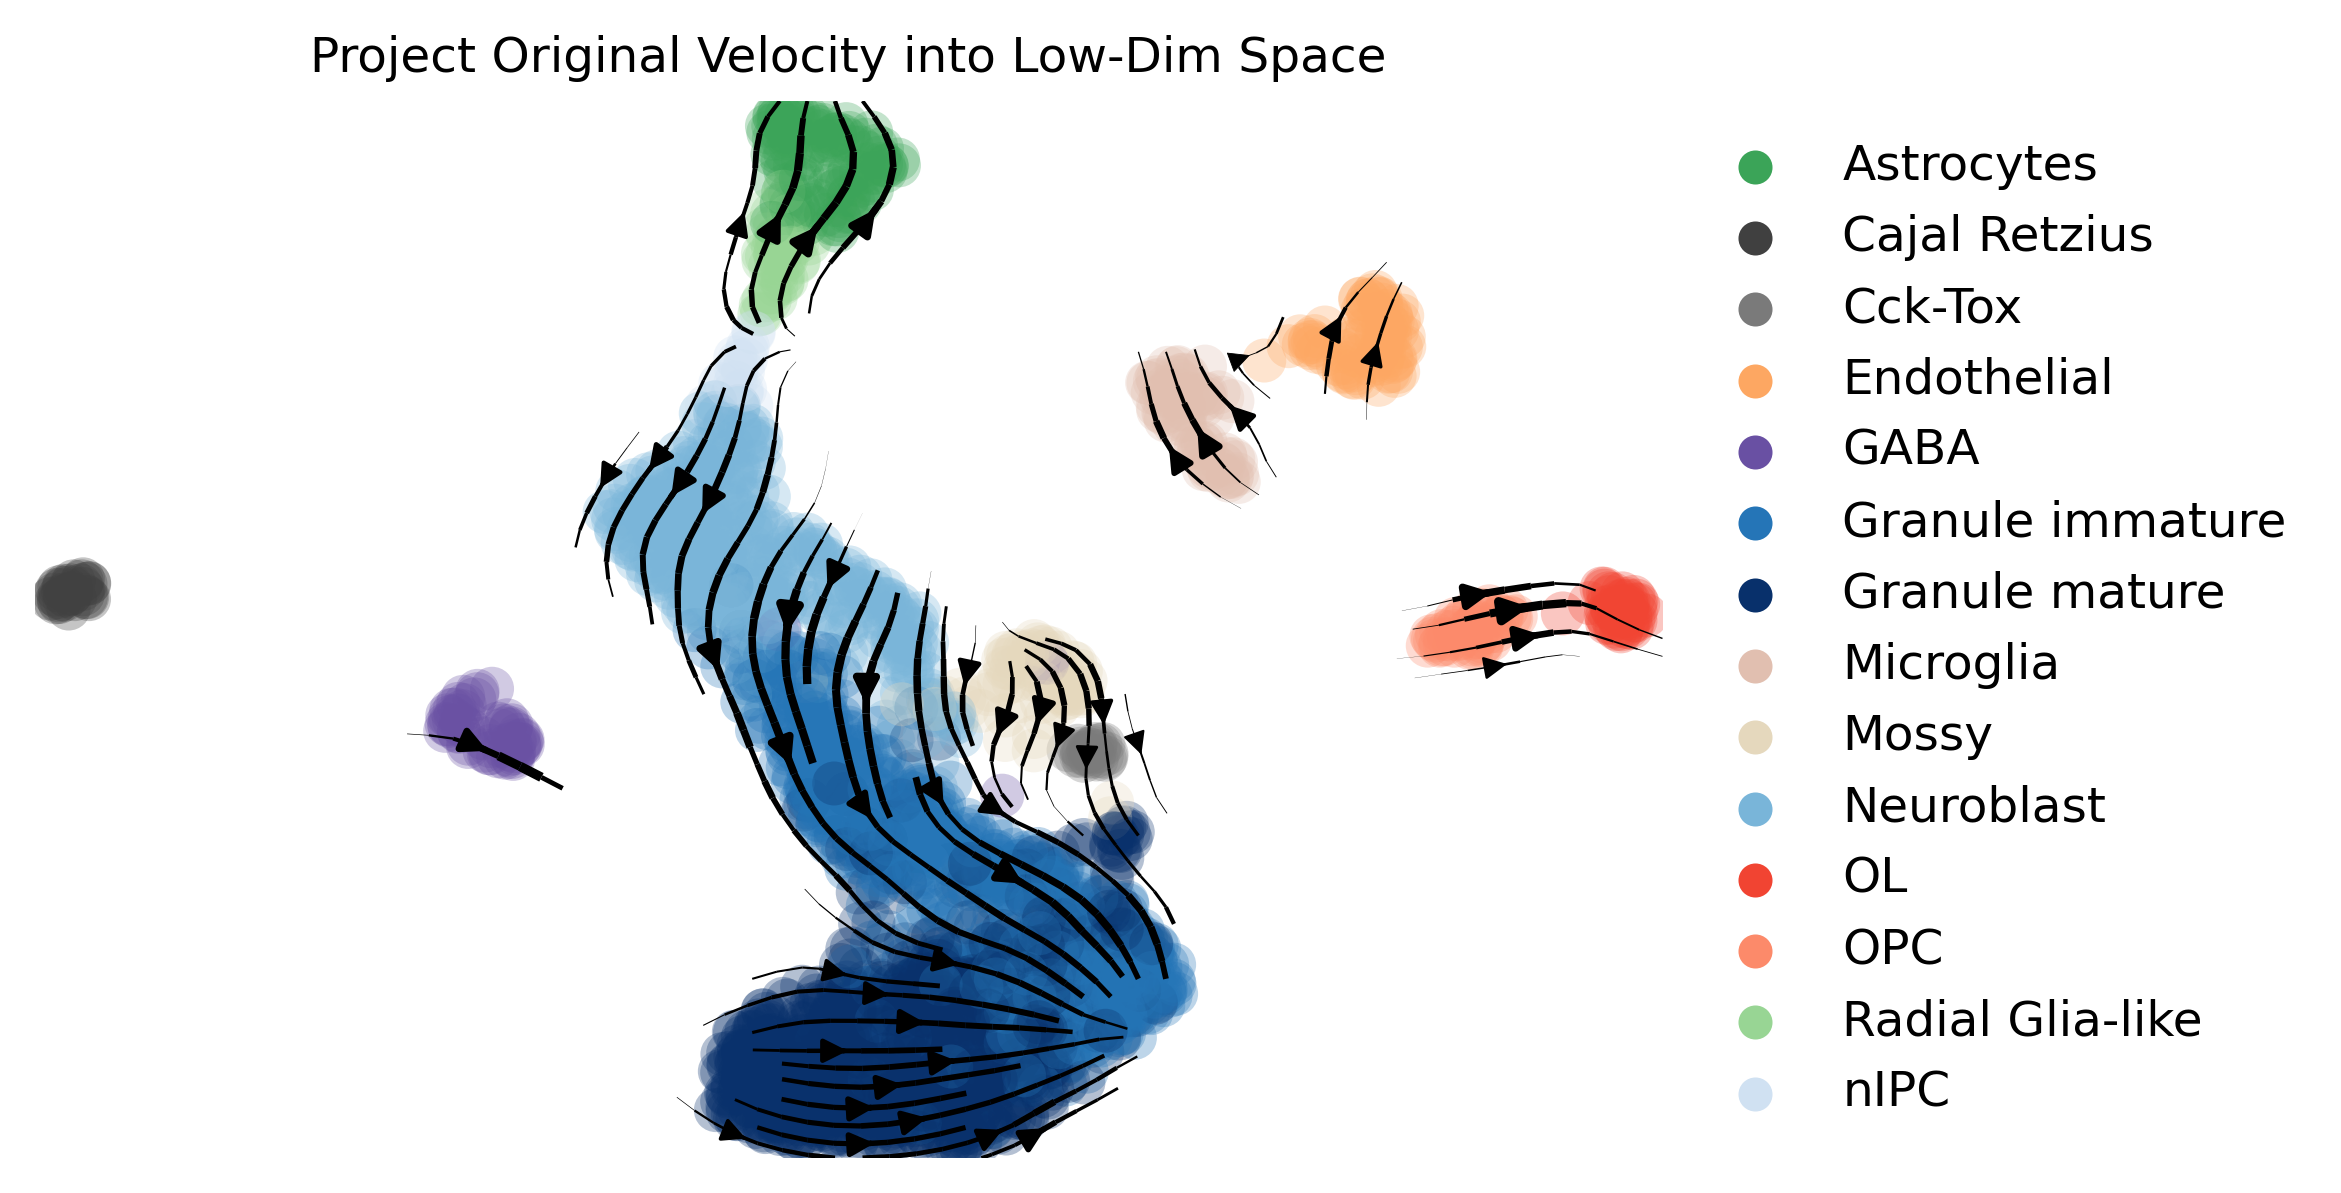

--> added 'vv_velocity_length' (adata.obs)
--> added 'vv_velocity_confidence' (adata.obs)
--> added 'vv_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('OPC', 'OL'): 0.8733754}
Total Mean: 0.873375415802002
# Cross-Boundary Velocity Coherence (A->B)
{('OPC', 'OL'): 0.93672705}
Total Mean: 0.9367270469665527
# Cross-Boundary Direction Correctness (A->B)
{('OPC', 'OL'): 0.9862757180529258}
Total Mean: 0.9862757180529258
# In-cluster Coherence
{'Astrocytes': 0.9918907, 'Cajal Retzius': 0.9992751, 'Cck-Tox': 0.9989395, 'Endothelial': 0.97057843, 'GABA': 0.99707127, 'Granule immature': 0.9983035, 'Granule mature': 0.9984463, 'Microglia': 0.9755324, 'Mossy': 0.99234366, 'Neuroblast': 0.9929977, 'OL': 0.9863475, 'OPC': 0.99796754, 'Radial Glia-like': 0.9917799, 'nIPC': 0.9568302}
Total Mean: 0.9891646504402161
# In-cluster Confidence
{'Astrocytes': 0.9912050038576126, 'Cajal Retzius': 0.9991021489395815, 'Cck-Tox': 0.9979760139076798, 'Endothelial': 0.96

In [10]:
def exp(adata, exp_metrics):
    new_v_key="vv_velocity"
    x = model.encoder(tensor_x).detach().cpu().numpy()
    s = model.encoder(tensor_s).detach().cpu().numpy()
    u = model.encoder(tensor_u).detach().cpu().numpy()
    v = model.encoder(tensor_s + tensor_v).detach().cpu().numpy() - s
    
    adata = new_adata(adata, x, s, u, v, False, new_v_key=new_v_key)
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    scv.tl.velocity_graph(adata, vkey=new_v_key)
    scv.pl.velocity_embedding_stream(adata, legend_loc='right_margin', vkey=new_v_key, basis='X_umap', color=['clusters'], #, 'age(days)'],
                                    title="Project Original Velocity into Low-Dim Space",
                                    dpi=350,
                                    )  
    scv.tl.velocity_confidence(adata, vkey=new_v_key)
    exp_metrics['Cohort AutoEncoder'] = evaluate(adata, cluster_edges, k_cluster, new_v_key)
    return x, s, u, v

x, s, u, v = exp(adata, exp_metrics)

In [11]:
import hilearn
def abline(x_vals, y_vals):
    hilearn.corr_plot(x_vals, y_vals, outlier=0)


In [12]:
sel_opc = adata.obs.clusters == "OPC"
sel_ol = adata.obs.clusters == "OL"

(100,) (100,)
74.2% are consistent


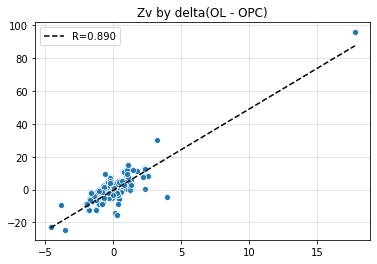

In [13]:
sel = np.ones(args.z_dim, dtype=np.bool)
median_Vu = np.median(v[sel_opc], axis=0)
median_deltaSu = np.median(np.median(s[sel_ol], axis=0) - s[sel_opc], axis=0)

print(median_Vu.shape, median_deltaSu.shape)
max_thred, min_thred = np.percentile(median_Vu, 99), np.percentile(median_Vu, 1)
sel = sel & (median_Vu < max_thred) & (median_Vu > min_thred)

max_thred, min_thred = np.percentile(median_deltaSu, 99), np.percentile(median_deltaSu, 1)
sel = sel & (median_deltaSu < max_thred) & (median_deltaSu > min_thred)

consist = len([1 for _v, _ds in zip(median_Vu[sel], median_deltaSu[sel]) if _v * _ds > 0])
contradict = len([1 for _v, _ds in zip(median_Vu[sel], median_deltaSu[sel]) if _v * _ds < 0])
print("{:.1%} are consistent".format(consist / (consist + contradict)))

abline(median_Vu, median_deltaSu)
ax = sns.scatterplot(median_Vu, median_deltaSu)

plt.title("Zv by delta(OL - OPC)")
ax.get_figure().savefig(f"./figures/{args.exp_name}_low_dim_v_by_delta_s.png",dpi=350)

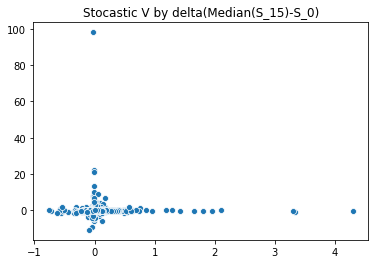

In [14]:
ax = sns.scatterplot(np.median(adata.layers['stc_velocity'][sel_opc], axis=0), np.median(np.median(spliced[sel_ol], axis=0) - spliced[sel_opc], axis=0))
plt.title("Stocastic V by delta(Median(S_15)-S_0)")
ax.get_figure().savefig(f"./figures/{args.exp_name}_stc_v_by_delta_s_full_data.png",dpi=350)

(2000,) (2000,)


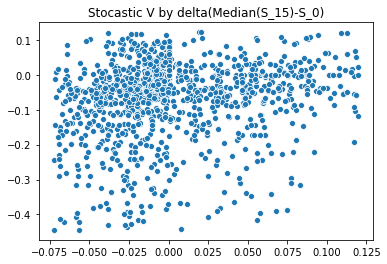

In [15]:
sel = np.ones(adata.X.shape[1], dtype=np.bool)
median_stc = np.median(adata.layers['stc_velocity'][sel_opc], axis=0)
median_deltaS = np.median(np.median(spliced[sel_ol], axis=0) - spliced[sel_opc], axis=0)

print(median_stc.shape, median_deltaS.shape)
max_thred, min_thred = np.percentile(median_stc, 90), np.percentile(median_stc, 10)
sel = sel & (median_stc < max_thred) & (median_stc > min_thred)

max_thred, min_thred = np.percentile(median_deltaS, 90), np.percentile(median_deltaS, 10)
sel = sel & (median_deltaS < max_thred) & (median_deltaS > min_thred)

ax = sns.scatterplot(median_stc[sel], median_deltaS[sel])
plt.title("Stocastic V by delta(Median(S_15)-S_0)")
ax.get_figure().savefig(f"./figures/{args.exp_name}_stc_v_by_delta_s.png",dpi=350)

41.1% are opposite


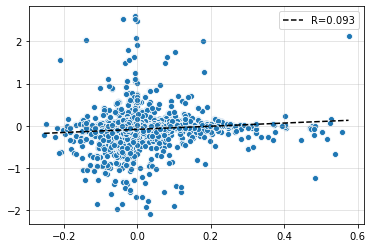

In [16]:
sel = np.ones(adata.X.shape[1], dtype=np.bool)
max_thred, min_thred = np.percentile(median_stc, 99), np.percentile(median_stc, 1)
sel = sel & (median_stc < max_thred) & (median_stc > min_thred)

max_thred, min_thred = np.percentile(median_deltaS, 99), np.percentile(median_deltaS, 1)
sel = sel & (median_deltaS < max_thred) & (median_deltaS > min_thred)

abline(median_stc[sel], median_deltaS[sel])
sns.scatterplot(median_stc[sel], median_deltaS[sel])
consist = len([1 for _v, _ds in zip(median_stc[sel], median_deltaS[sel]) if _v * _ds > 0])
contradict = len([1 for _v, _ds in zip(median_stc[sel], median_deltaS[sel]) if _v * _ds < 0])
print("{:.1%} are opposite".format(contradict /(contradict + consist)))

(2000,) (2000,)


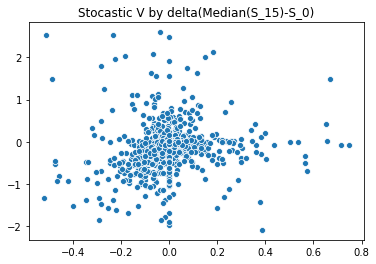

In [17]:
sel = np.ones(adata.X.shape[1], dtype=np.bool)
median_stc = np.median(adata.layers['dyn_velocity'][sel_opc], axis=0)
median_deltaS = np.median(np.median(spliced[sel_ol], axis=0) - spliced[sel_opc], axis=0)

print(median_stc.shape, median_deltaS.shape)
max_thred, min_thred = np.percentile(median_stc, 99), np.percentile(median_stc, 1)
sel = sel & (median_stc < max_thred) & (median_stc > min_thred)

max_thred, min_thred = np.percentile(median_deltaS, 99), np.percentile(median_deltaS, 1)
sel = sel & (median_deltaS < max_thred) & (median_deltaS > min_thred)

ax = sns.scatterplot(median_stc[sel], median_deltaS[sel])
plt.title("Stocastic V by delta(Median(S_15)-S_0)")
ax.get_figure().savefig(f"./figures/{args.exp_name}_dynamical_v_by_delta_s.png",dpi=350)